### Introduction/Business Problem



The goal of this project is to predict the severity of road accidents at certain locations based on various conditions. One of the target audience of the model is GPS applications like Google Map.

When a user types in a destination and starts using the navigation function in the app, the app would prompt a warning if the place he is heading to or somewhere in the route is predicted to have a high chance of severe accident under the current conditions. The navigator could as well recommend a route that takes longer time but has lower risk to the user.


#### Benefits of this project:


This would help the users reduce chances of getting fatal or severe injury. If a user receives the warning, he could cancel his plan or change to a safer route. 

It is a good opportunity for the tech companies to make use of big data resources to show humanistic care to the communities. Reducing chances of traffic accidents can in turn help saving costs of municipal services like police and ambulance.


## Data


This project will use the sample "Data-Collisions.csv" file provided by the course to train the prediction model of traffic accidents' severity. The data contains accident records in Seattle of a date range from Jan 01, 2004 to May 02, 2020. There are 194673 events in the data set in total.

Based on the definition of our problem, the factors that will used in the prediction of severity of road accidents include:

* Geographical location
* Number of vehicles involved
* Weather factors (e.g., weather, road conditions, light conditions)
* Time of day
* Along with the severity level of the accident


These inputs are selected because they can be easily collected in real time at the moment an accident is reported.

As a result, the following attributes will be analyzed:

* The coordinates of the accident location X, Y
* VEHCOUNT which shows number of vehicles  involved
* WEATHER, ROADCOND, LIGHTCOND
* INCDTTM
* SEVERITYCODE


Example of the data:

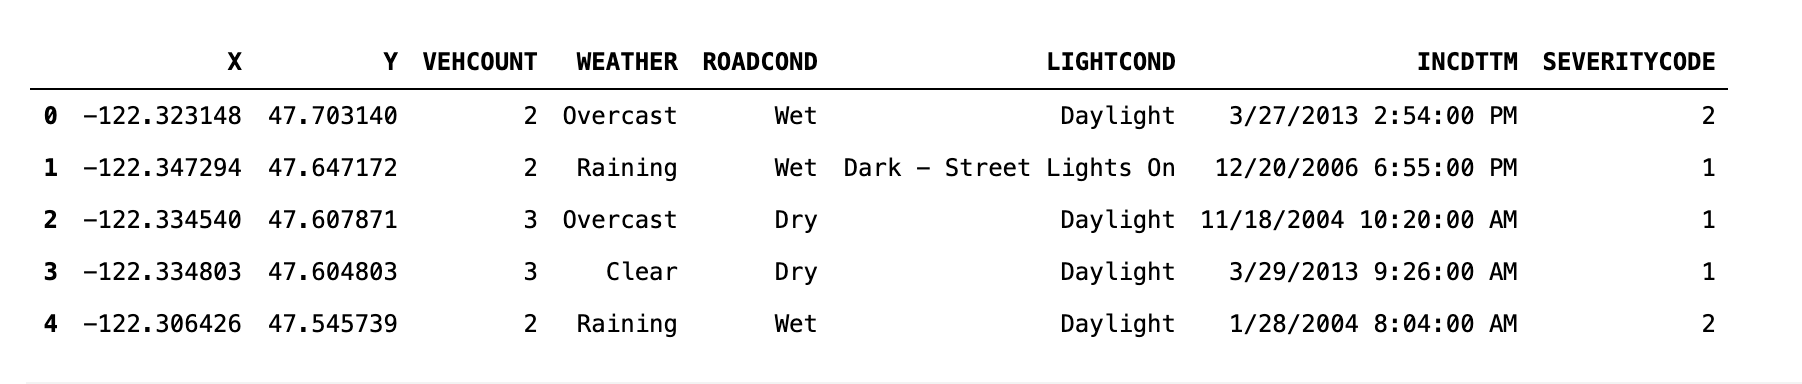

## Methodology

The problem will be solved using logistical regression models, determining the probability that the target variable is 'True'.

These variables are chosen because they are easily gathered in real time at the moment an accident is reported.

### Data cleanup and preprocessing

In [135]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

In [136]:
df = pd.read_csv("Data-Collisions.csv")
df.head()

/Users/zihanliu/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


In [137]:
df_select = df[["X", "Y", "VEHCOUNT", "WEATHER", "ROADCOND", "LIGHTCOND", "INCDTTM", "SEVERITYCODE"]]
df_select.shape

(194673, 8)

Firstly, let's delete the data rows which are lack of information in one of these attributes.

In [138]:
df_select=df_select.dropna()
df_select.shape

(184167, 8)

In [100]:
df_select.head()

,X,Y,VEHCOUNT,WEATHER,ROADCOND,LIGHTCOND,INCDTTM,SEVERITYCODE
0,-122.323148,47.703140,2,Overcast,Wet,Daylight,3/27/2013 2:54:00 PM,2
1,-122.347294,47.647172,2,Raining,Wet,Dark - Street Lights On,12/20/2006 6:55:00 PM,1
2,-122.334540,47.607871,3,Overcast,Dry,Daylight,11/18/2004 10:20:00 AM,1
3,-122.334803,47.604803,3,Clear,Dry,Daylight,3/29/2013 9:26:00 AM,1
4,-122.306426,47.545739,2,Raining,Wet,Daylight,1/28/2004 8:04:00 AM,2


In [31]:
df_select['WEATHER'].value_counts()

Clear                       108833
Raining                      31987
Overcast                     27105
Unknown                      13846
Snowing                        888
Other                          765
Fog/Smog/Smoke                 553
Sleet/Hail/Freezing Rain       112
Blowing Sand/Dirt               49
Severe Crosswind                24
Partly Cloudy                    5
Name: WEATHER, dtype: int64

In [33]:
df_select['ROADCOND'].value_counts()

Dry               121871
Wet                46009
Unknown            13795
Ice                 1174
Snow/Slush           984
Other                116
Standing Water       102
Sand/Mud/Dirt         63
Oil                   53
Name: ROADCOND, dtype: int64

In [34]:
df_select['LIGHTCOND'].value_counts()

Daylight                    113522
Dark - Street Lights On      47250
Unknown                      12416
Dusk                          5763
Dawn                          2422
Dark - No Street Lights       1450
Dark - Street Lights Off      1145
Other                          188
Dark - Unknown Lighting         11
Name: LIGHTCOND, dtype: int64

We can see that the weather conditions, road conditions and light conditions are various, thus we need to combine these levels into less levels before we change them into numerical values. These three attributes all contains "Unknown" rows and "Other" rows which would decrease the accuracy of our model since make it to any explicit level would affact the final results.

Let's delete the rows that mark "Unknown" or "Other" in these three columns.

In [139]:
indexNames = df_select[(df_select['WEATHER'] == 'Unknown') | (df_select['WEATHER'] == 'Other') 
                       | (df_select['ROADCOND'] == 'Unknown') | (df_select['ROADCOND'] == 'Other')
                       | (df_select['LIGHTCOND'] == 'Unknown') | (df_select['LIGHTCOND'] == 'Other')
                      ].index

df_select.drop(indexNames , inplace=True)


In [102]:
df_select.shape

(166217, 8)

In [103]:
df_select['WEATHER'].value_counts()

Clear                       106752
Raining                      31559
Overcast                     26379
Snowing                        813
Fog/Smog/Smoke                 537
Sleet/Hail/Freezing Rain       106
Blowing Sand/Dirt               42
Severe Crosswind                24
Partly Cloudy                    5
Name: WEATHER, dtype: int64

Firstly let's deal with the WEATHER attribute. According to our natural cognition, all these different conditions can classify into precipitation or not.  

In [140]:
def is_precipitation(weather_string):
    if (weather_string == 'Raining' or weather_string == 'Snowing' or weather_string == 'Sleet/Hail/Freezing Rain'
        or weather_string == 'Blowing Sand/Dirt' or weather_string == 'Fog/Smog/Smoke'):
        return 1
    return 0

df_select['Precipitation'] = df_select.apply(lambda x : is_precipitation(x['WEATHER']), axis=1)
df_select.head()  

,X,Y,VEHCOUNT,WEATHER,ROADCOND,LIGHTCOND,INCDTTM,SEVERITYCODE,Precipitation
0,-122.323148,47.703140,2,Overcast,Wet,Daylight,3/27/2013 2:54:00 PM,2,0
1,-122.347294,47.647172,2,Raining,Wet,Dark - Street Lights On,12/20/2006 6:55:00 PM,1,1
2,-122.334540,47.607871,3,Overcast,Dry,Daylight,11/18/2004 10:20:00 AM,1,0
3,-122.334803,47.604803,3,Clear,Dry,Daylight,3/29/2013 9:26:00 AM,1,0
4,-122.306426,47.545739,2,Raining,Wet,Daylight,1/28/2004 8:04:00 AM,2,1


Secondly let's deal with the ROADCOND attribute. According to our natural cognition, all these different conditions can classify into Slippery or not.

In [129]:
df_select['ROADCOND'].value_counts()

Dry               119167
Wet                44975
Ice                 1055
Snow/Slush           821
Standing Water        94
Sand/Mud/Dirt         56
Oil                   49
Name: ROADCOND, dtype: int64

In [141]:
def is_slippery(roadcond_string):
    if (roadcond_string == 'Dry'):
        return 0
    return 1

df_select['Slippery'] = df_select.apply(lambda x : is_slippery(x['ROADCOND']), axis=1)
df_select.head()

,X,Y,VEHCOUNT,WEATHER,ROADCOND,LIGHTCOND,INCDTTM,SEVERITYCODE,Precipitation,Slippery
0,-122.323148,47.703140,2,Overcast,Wet,Daylight,3/27/2013 2:54:00 PM,2,0,1
1,-122.347294,47.647172,2,Raining,Wet,Dark - Street Lights On,12/20/2006 6:55:00 PM,1,1,1
2,-122.334540,47.607871,3,Overcast,Dry,Daylight,11/18/2004 10:20:00 AM,1,0,0
3,-122.334803,47.604803,3,Clear,Dry,Daylight,3/29/2013 9:26:00 AM,1,0,0
4,-122.306426,47.545739,2,Raining,Wet,Daylight,1/28/2004 8:04:00 AM,2,1,1


So far, the WEATHER and ROADCOND can be deleted from the dataframe.

In [142]:
df_select.drop(columns=['WEATHER', 'ROADCOND'], inplace=True)
df_select.head()

,X,Y,VEHCOUNT,LIGHTCOND,INCDTTM,SEVERITYCODE,Precipitation,Slippery
0,-122.323148,47.703140,2,Daylight,3/27/2013 2:54:00 PM,2,0,1
1,-122.347294,47.647172,2,Dark - Street Lights On,12/20/2006 6:55:00 PM,1,1,1
2,-122.334540,47.607871,3,Daylight,11/18/2004 10:20:00 AM,1,0,0
3,-122.334803,47.604803,3,Daylight,3/29/2013 9:26:00 AM,1,0,0
4,-122.306426,47.545739,2,Daylight,1/28/2004 8:04:00 AM,2,1,1


Now let's deal with the LIGHTCOND. As we observe the different light conditions in the record, we can easily realize that these levels represent different levels of light. Thus we had better convert this categorical variable into numerical variable using label encoder. It make senses that different numbers will represent different level of lights. There are too many levels for dark light situations so that we had better rearrange them first.

In [132]:
df_select['LIGHTCOND'].value_counts()

Daylight                    110315
Dark - Street Lights On      45621
Dusk                          5532
Dawn                          2337
Dark - No Street Lights       1333
Dark - Street Lights Off      1071
Dark - Unknown Lighting          8
Name: LIGHTCOND, dtype: int64

In [143]:
def simplify_lightcond(light_string):
    if (light_string == 'Dark - No Street Lights' or light_string == 'Dark - Street Lights Off'):
        return 'Dark without lights'
    if (light_string == 'Dark - Unknown Lighting' or light_string == 'Dark - Street Lights On'):
        return 'Dark with lights'
    if (light_string == 'Dusk' or light_string == 'Dawn'):
        return 'Slight light'
    return light_string


df_select['LIGHTCOND'] = df_select.apply(lambda x : simplify_lightcond(x['LIGHTCOND']), axis=1)

In [144]:
df_select['LIGHTCOND'].value_counts()

Daylight               110315
Dark with lights        45629
Slight light             7869
Dark without lights      2404
Name: LIGHTCOND, dtype: int64

In [145]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
df_select['NEWLIGHTCOND'] = labelencoder.fit_transform(df_select['LIGHTCOND'])
df_select.drop('LIGHTCOND', axis=1, inplace=True)
df_select.rename(columns={"NEWLIGHTCOND": "LIGHTCOND"}, inplace=True)
df_select.head()

,X,Y,VEHCOUNT,INCDTTM,SEVERITYCODE,Precipitation,Slippery,LIGHTCOND
0,-122.323148,47.703140,2,3/27/2013 2:54:00 PM,2,0,1,2
1,-122.347294,47.647172,2,12/20/2006 6:55:00 PM,1,1,1,0
2,-122.334540,47.607871,3,11/18/2004 10:20:00 AM,1,0,0,2
3,-122.334803,47.604803,3,3/29/2013 9:26:00 AM,1,0,0,2
4,-122.306426,47.545739,2,1/28/2004 8:04:00 AM,2,1,1,2


## Now it is turn to process the INCDTTM variable to get a number which represents the time of day in each record. We need to parse the time string to get the time.

In [147]:
from datetime import datetime
# During the processing it shows there are some data rows are lack of time of the day info. 
# Thus I turn data like this into'0' so that it is easy to be deleted later on
def get_time_of_day(time_str):
    if len(time_str) <= 10:
        return 0
    timeobj = datetime.strptime(time_str, '%m/%d/%Y %I:%M:%S %p')
    return timeobj.timestamp() % 86400

df_select['INCDTTM'] = df_select.apply(lambda x : get_time_of_day(x['INCDTTM']), axis=1)
df_select.head()

,X,Y,VEHCOUNT,INCDTTM,SEVERITYCODE,Precipitation,Slippery,LIGHTCOND
0,-122.323148,47.703140,2,24840.0,2,0,1,2
1,-122.347294,47.647172,2,39300.0,1,1,1,0
2,-122.334540,47.607871,3,8400.0,1,0,0,2
3,-122.334803,47.604803,3,5160.0,1,0,0,2
4,-122.306426,47.545739,2,240.0,2,1,1,2


Now let's delete the datas which INCDTTM column is 0

In [150]:
indexName1 = df_select[df_select['INCDTTM'] == 0].index
df_select.drop(indexName1, inplace=True)
df_select.shape

(143568, 8)

In [153]:
df_select['VEHCOUNT'] = df_select['VEHCOUNT'].astype('int')

# Train Logistic Regression Model.

## Creating Training/Testing sets

Let's define the feature set and the result set.

In [163]:
features = np.asarray(df_select[['X', 'Y', 'VEHCOUNT', 'INCDTTM', 'Precipitation', 'Slippery', 'LIGHTCOND']])
features[0:5]

array([[-1.22323148e+02,  4.77031403e+01,  2.00000000e+00,
         2.48400000e+04,  0.00000000e+00,  1.00000000e+00,
         2.00000000e+00],
       [-1.22347294e+02,  4.76471725e+01,  2.00000000e+00,
         3.93000000e+04,  1.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [-1.22334540e+02,  4.76078714e+01,  3.00000000e+00,
         8.40000000e+03,  0.00000000e+00,  0.00000000e+00,
         2.00000000e+00],
       [-1.22334803e+02,  4.76048029e+01,  3.00000000e+00,
         5.16000000e+03,  0.00000000e+00,  0.00000000e+00,
         2.00000000e+00],
       [-1.22306426e+02,  4.75457395e+01,  2.00000000e+00,
         2.40000000e+02,  1.00000000e+00,  1.00000000e+00,
         2.00000000e+00]])

In [164]:
results = np.asarray(df_select['SEVERITYCODE'])
results[0:5]

array([2, 1, 1, 1, 2])

In [166]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, results, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape, y_train.shape)
print ('Test set:', X_test.shape, y_test.shape)

Train set: (114854, 7) (114854,)
Test set: (28714, 7) (28714,)


## Normalize training data

In [170]:
from sklearn import preprocessing
normalized_train_X= preprocessing.StandardScaler().fit(X_train).transform(X_train)
normalized_train_X[0:5]

array([[-0.09885777,  0.53794131,  0.05269116, -1.47744574, -0.49857387,
        -0.62934785,  0.54896495],
       [-0.90574397,  1.26741473,  0.05269116, -0.70118405, -0.49857387,
        -0.62934785,  0.54896495],
       [-0.82366081,  0.52569259,  3.50592418, -0.5847448 , -0.49857387,
        -0.62934785,  0.54896495],
       [-0.95118484,  0.10493691,  0.05269116, -0.60137898, -0.49857387,
         1.5889464 ,  0.54896495],
       [ 0.04200691, -0.8267832 ,  0.05269116, -0.64573679, -0.49857387,
        -0.62934785,  0.54896495]])

## Normalize testing data

In [171]:
normalized_test_X = preprocessing.StandardScaler().fit(X_test).transform(X_test)
normalized_test_X

array([[-1.55770701, -1.3110814 ,  0.04409666, ...,  2.01399401,
         1.60480383, -1.56361257],
       [ 0.24069887,  2.02164248,  0.04409666, ..., -0.49652581,
         1.60480383, -1.56361257],
       [ 0.58751476, -1.24974848,  0.04409666, ..., -0.49652581,
        -0.62312912,  0.54692996],
       ...,
       [ 0.48184422,  1.00352869,  1.77623281, ..., -0.49652581,
        -0.62312912,  0.54692996],
       [-2.62010016, -0.74551183,  0.04409666, ..., -0.49652581,
        -0.62312912, -1.56361257],
       [ 0.57929359, -0.38166709,  0.04409666, ...,  2.01399401,
         1.60480383, -0.5083413 ]])

Now we have finished cleaning up and preprocessing the data. Next we can start using Logistic Regresson model to train the dataset and get the result.

# Results and Evaluation--Modeling (Logistic Regression with Scikit-learn)

In [172]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(C=0.01, solver='liblinear').fit(normalized_train_X,y_train)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [173]:
yhat = LR.predict(normalized_test_X)
yhat

array([1, 1, 1, ..., 1, 1, 1])

## Jaccard Index

Lets try jaccard index for accuracy evaluation

In [174]:
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, yhat)

/Users/zihanliu/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


0.6684544124817162

## log loss

Now, lets try log loss for evaluation.

In [175]:
from sklearn.metrics import log_loss
yhat_prob = LR.predict_proba(normalized_test_X)
yhat_prob
log_loss(y_test, yhat_prob)

0.6313322949241933

# Discussion

In the results above, we used Logisitic Regression to attempt to add a warning function of Seattle Washington district in navigation apps.The Logistic Regression model we used has up to 66.8% accuracy of predicting traffic severity levels in Seattle.

During preprocessing the data, I deleted all the row data which don't have explicitly information in the variables that were selected eventhough they noted 'Unknown' or 'Other'. The reason was because this kind of information would give no indication comparing to other categories but would affect the final accuracy if I combine them into other categories which have apparent indication.

Thus due to strict data info requirements of the dataset, the original dataset dropped from 194673 rows to 143568 rows before it get trained. According to this, the apps should be able to access other APIs to guarantee that all required variables can be provided other than X/Y coordinates when using this model to provide predictions of severity of accidents.

# Conclusion

Purpose of this project was to utilize the collision data records of Seattle to build a model which can predict the severity of road accidents in this area so that it can help the Seattle residents reduce chances of getting fatal or severe injury.

The prediction of this model would be used to give navigation users a warning if necessary. But the final decision of wether to go out or not after receiving a severity warning would still be made by individuals based on their personal requirements and needs.

To evaluate the model performance in real life, not only the prediction accuracy counts, additional factors should be taken into considerate.